This example assumes that you have an [ChatBase](https://www.chatbase.co) bot active and running, while its configuration is stored in a _config.py_ file nearby.
As a predictor, we use [txai_omics_3](https://github.com/SermanVS/txai_omics_3).

In [1]:
from llamba.chatmodels.chatbase import ChatbaseModel
import llamba.plots as bplt
import config

### Initialize a chatbot and test that it works

In [2]:
chatbot = ChatbaseModel(url=config.URL_CB, api_key=config.API_KEY_CB, chatbot_id=config.ID_CB)
res = chatbot.query('What does an increased level of albumin mean?')
print(res)

(True, 'Albumin is a protein in the blood that helps maintain fluid balance. An increased level of albumin can indicate dehydration or a high-protein diet.')


### Get a bioage model

In [3]:
from pathlib import Path
import os
import shap
import numpy as np
import pickle
import torch
from txai_omics_3.models.tabular.widedeep.ft_transformer import WDFTTransformerModel
from llamba.bioage_model import BioAgeModel

root_dir = Path(os.getcwd()).parent

# Model
fn_model = f"../../txai_omics_3/data/immuno/model.ckpt"
model = WDFTTransformerModel.load_from_checkpoint(checkpoint_path=fn_model)
bioage_model = BioAgeModel(model=model)

# SHAP
fn_shap = f"../../txai_omics_3/data/immuno/shap.pickle"

def predict_func(x):
    batch = {
        'all': torch.from_numpy(np.float32(x)),
        'continuous': torch.from_numpy(np.float32(x)),
        'categorical': torch.from_numpy(np.int32(x[:, []])),
    }
    return model(batch).cpu().detach().numpy()
with open(fn_shap, 'rb') as handle:
    shap_dict = pickle.load(handle)

Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint h:\Lobachevsky\txai_omics_3\data\immuno\model.ckpt`
Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.


### Load data

In [4]:
import pandas as pd

my_data = {'CXCL9': 2599.629474, 
           'CCL22': 820.306524, 
           'IL6': 0.846377, 
           'PDGFB': 13400.666359, 
           'CD40LG': 1853.847406, 
           'IL27': 1128.886982,
           'VEGFA': 153.574220,
           'CSF1': 239.627236,
           'PDGFA': 1005.844290,
           'CXCL10': 228.229829,
           'Age': 90.454972 }

my_df = pd.DataFrame(my_data, index=[0])

# Model data

train_data = pd.read_excel(f"../../txai_omics_3/data/immuno/data.xlsx")

### Initialize a connector

In [5]:
from llamba.connector import LlambaConnector

connector = LlambaConnector(bioage_model=bioage_model, chat_model=chatbot)

### Run an analysis task

In [6]:
res = connector.analyze(data=my_df, shap_dict=shap_dict)
print(res['analysis'])

Your bioage is 79 and your aging acceleration is -11, which means you are ageing slower than normal.

Here is some more information about your data. 

CXCL9: 2599.629474
CXCL9 is a proinflammatory cytokine associated with inflammatory reactions and cardiovascular risk. An increased level of CXCL9 can indicate systemic chronic inflammation and age-related cardiovascular issues.

CD40LG: 1853.847406
Hmm, I am not sure.




h:\Lobachevsky\FrameworkLib\.venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


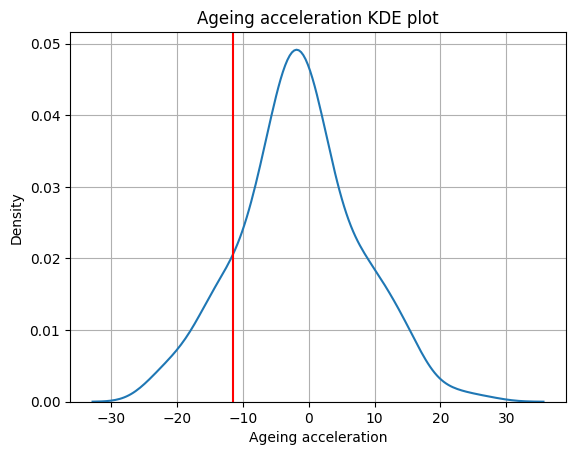

In [18]:
kde = bplt.kde_plot(res['acceleration'], train_data['SImAge acceleration'])

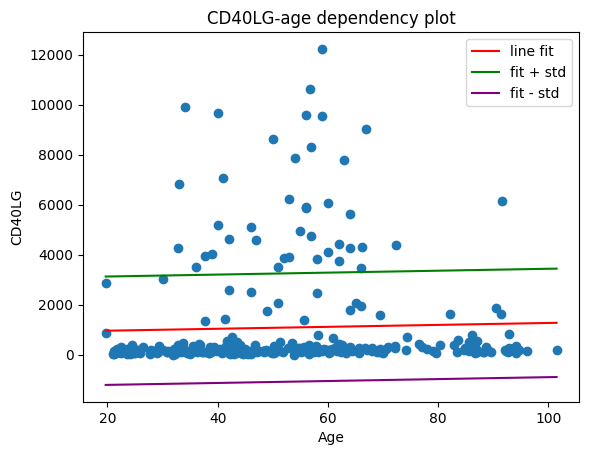

In [22]:
kde = bplt.feat_plot(train_data['CD40LG'], train_data['Age'], res['features'], feat='CD40LG')